In [2]:
import torch
import sys
sys.path.append("/home/onyxia/work/Advanced-ML")
from data import S3ParquetReader
from config import USER
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from models import AutoEncoder, train_model, CombinedLoss
from torch.optim import Adam
from sklearn.preprocessing import StandardScaler

# Data Loading

In [3]:
# load data from s3 storage
BUCKET = f"/{USER}/jane_street_data"
reader = S3ParquetReader(bucket=BUCKET)
FILE_KEY_S3 = "preprocessed.parquet/data_clean_symb_1.parquet"

data = reader.read_parquet(FILE_KEY_S3)
data.head()

date_id,feature_05,feature_06,feature_07,feature_08,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_22,feature_23,feature_24,feature_25,feature_28,feature_29,feature_30,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_40,feature_41,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,…,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_responder_0_lagged,feature_responder_1_lagged,feature_responder_2_lagged,feature_responder_3_lagged,feature_responder_4_lagged,feature_responder_5_lagged,feature_responder_6_lagged,feature_responder_7_lagged,feature_responder_8_lagged,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8,symbol_id,time_id,weight
i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i16,f32
0,0.127298,0.339121,-0.045494,0.151473,-0.038995,-0.644192,-0.193971,-0.016662,-0.213108,-0.045016,0.014899,0.128033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.397016,0.694868,0.812098,-0.128621,0.025559,0.018694,-0.006306,-1.706433,-0.490941,0.425017,0.281025,-0.134582,0.046605,-0.059343,-0.751958,-0.314242,…,0.085259,-0.324355,-0.097414,-0.296044,0.21344,-0.20025,-0.11987,-0.007101,-0.693186,-0.181427,0.073886,-0.062266,0.136151,0.110356,0.055748,-0.028266,0.573992,-0.319932,-0.335376,-0.21128,-0.279558,-0.434355,-1.220439,0.214211,-0.257941,0.36224,-0.376568,-0.086291,-0.392552,-0.267725,-0.112329,-1.233082,0.131704,-0.024239,1,35,3.889038
0,0.114208,-1.419921,-0.505525,-0.258195,0.017889,-0.254385,0.015691,-0.020583,-0.15111,-0.034961,-0.045215,-0.411787,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.037745,-0.824408,-0.312367,0.272155,0.041673,0.051002,0.101001,-0.172871,0.356697,0.43781,-0.243426,0.116691,0.21925,-0.059218,-0.298613,0.029315,…,-0.067586,0.22172,0.347892,0.511532,-0.214167,-0.045423,-0.048534,0.048807,-0.407794,0.008081,-0.071584,0.056597,0.01653,-0.049644,-0.023103,-0.0531,0.36224,-0.376568,-0.086291,-0.392552,-0.267725,-0.112329,-1.233082,0.131704,-0.024239,0.283566,-0.397785,0.041572,0.001317,-0.112683,0.419467,-0.578848,0.269364,0.459819,1,36,3.889038
0,0.118826,-1.293755,-0.809856,0.268584,-0.056675,-0.273341,-0.016404,0.010669,0.172457,0.011381,0.013246,-0.016248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.571682,0.168574,-0.042331,-0.55658,0.175519,-0.052067,0.053939,0.109843,-0.055707,-0.214608,-0.026042,-0.180718,-0.171372,-0.019658,-0.084493,-0.116301,…,-0.100162,-0.029472,0.037072,0.097566,0.061552,-0.136708,-0.029742,-0.047774,-0.150518,-0.287006,-0.000054,-0.048201,-0.093462,-0.015866,0.051347,0.055587,0.283566,-0.397785,0.041572,0.001317,-0.112683,0.419467,-0.578848,0.269364,0.459819,0.260547,-0.299865,0.239627,-0.019651,-0.194262,0.321798,-0.683034,0.027111,0.075722,1,37,3.889038
0,-0.216346,-0.021069,-0.425764,-0.005701,-0.010654,0.302838,0.000491,-0.017648,-0.036415,-0.008958,0.384812,0.49453,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.202302,0.395804,-0.512155,0.642004,0.414221,0.113961,-0.131998,-0.374575,0.206433,-0.445924,-0.518108,0.268771,0.069906,0.207732,-0.046667,-0.266864,…,0.036929,-0.176699,-0.503255,-0.449954,-0.134894,0.050516,-0.089379,0.004014,-0.204778,-0.144482,-0.082102,-0.050271,0.020269,-0.008658,0.096835,-0.042524,0.260547,-0.299865,0.239627,-0.019651,-0.194262,0.321798,-0.683034,0.027111,0.075722,0.423799,-0.195033,0.145029,-0.076218,-0.304814,0.098249,-0.606483,-0.01076,-0.134628,1,38,3.889038
0,-0.660073,2.168059,0.903407,-0.101644,0.133174,-0.212203,-0.217244,0.006182,-0.076704,-0.027879,0.249095,-0.431726,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.511043,-0.221639,-0.014473,-0.

In [4]:
# we pick responder_6 as the target (same target as the data challenge)
target = "responder_6"
features = [col for col in data.columns if "feature" in col]
X, y = data[features], data[target]

n = X.height
n_train = int(0.8 * n)
X_train_raw = X.slice(0, n_train)
y_train_raw = y.slice(0, n_train)
X_val_raw = X.slice(n_train)
y_val_raw = y.slice(n_train)

# Scaling
scaler_x = StandardScaler()
scaler_y = StandardScaler()

# We use .to_numpy() for the scalers
x_train_np = scaler_x.fit_transform(X_train_raw.to_numpy())
# Important: y must be 2D for the scaler
y_train_np = scaler_y.fit_transform(y_train_raw.to_numpy().reshape(-1, 1))

x_val_np = scaler_x.transform(X_val_raw.to_numpy())
y_val_np = scaler_y.transform(y_val_raw.to_numpy().reshape(-1, 1))

# Dataset Class
class TimeSeriesDataset(Dataset):
    def __init__(self, X_np, y_np):
        # We store them as tensors directly to avoid re-converting at each __getitem__
        self.X = torch.tensor(X_np, dtype=torch.float32)
        self.y = torch.tensor(y_np, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Instantiation
train_dataset = TimeSeriesDataset(x_train_np, y_train_np)
val_dataset = TimeSeriesDataset(x_val_np, y_val_np)

# Loader
train_data_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True, num_workers=8)
val_data_loader = DataLoader(val_dataset, batch_size=2048, shuffle=False, num_workers=8)

# Model Evaluation

  5%|▌         | 1/20 [00:09<03:01,  9.54s/it]

Epoch 01 | loss=551.342 | R2_rec_train=0.2879 | R2_rec_val=0.2448 | R2_sup_train=0.7646 | R2_sup_val=0.7745


 10%|█         | 2/20 [00:18<02:47,  9.29s/it]

Epoch 02 | loss=455.862 | R2_rec_train=0.3918 | R2_rec_val=0.2866 | R2_sup_train=0.8247 | R2_sup_val=0.7902


 15%|█▌        | 3/20 [00:26<02:25,  8.57s/it]

Epoch 03 | loss=432.116 | R2_rec_train=0.4319 | R2_rec_val=0.3148 | R2_sup_train=0.8256 | R2_sup_val=0.8000


 20%|██        | 4/20 [00:34<02:15,  8.48s/it]

Epoch 04 | loss=415.878 | R2_rec_train=0.4588 | R2_rec_val=0.3325 | R2_sup_train=0.8269 | R2_sup_val=0.8125


 25%|██▌       | 5/20 [00:43<02:10,  8.69s/it]

Epoch 05 | loss=410.778 | R2_rec_train=0.4660 | R2_rec_val=0.3434 | R2_sup_train=0.8281 | R2_sup_val=0.8254


 30%|███       | 6/20 [00:51<01:57,  8.42s/it]

Epoch 06 | loss=401.604 | R2_rec_train=0.4814 | R2_rec_val=0.3680 | R2_sup_train=0.8284 | R2_sup_val=0.8295


 35%|███▌      | 7/20 [01:00<01:51,  8.57s/it]

Epoch 07 | loss=406.218 | R2_rec_train=0.4734 | R2_rec_val=0.3790 | R2_sup_train=0.8285 | R2_sup_val=0.8333


 40%|████      | 8/20 [01:09<01:43,  8.64s/it]

Epoch 08 | loss=391.805 | R2_rec_train=0.4966 | R2_rec_val=0.3958 | R2_sup_train=0.8299 | R2_sup_val=0.8341


 45%|████▌     | 9/20 [01:17<01:32,  8.39s/it]

Epoch 09 | loss=388.049 | R2_rec_train=0.5023 | R2_rec_val=0.3808 | R2_sup_train=0.8307 | R2_sup_val=0.8372


 50%|█████     | 10/20 [01:25<01:23,  8.37s/it]

Epoch 10 | loss=385.070 | R2_rec_train=0.5070 | R2_rec_val=0.3971 | R2_sup_train=0.8311 | R2_sup_val=0.8424


 55%|█████▌    | 11/20 [01:33<01:15,  8.36s/it]

Epoch 11 | loss=383.133 | R2_rec_train=0.5104 | R2_rec_val=0.4021 | R2_sup_train=0.8314 | R2_sup_val=0.8179


 60%|██████    | 12/20 [01:41<01:06,  8.28s/it]

Epoch 12 | loss=380.878 | R2_rec_train=0.5145 | R2_rec_val=0.3919 | R2_sup_train=0.8310 | R2_sup_val=0.8349


 65%|██████▌   | 13/20 [01:50<00:58,  8.40s/it]

Epoch 13 | loss=385.770 | R2_rec_train=0.5054 | R2_rec_val=0.4015 | R2_sup_train=0.8317 | R2_sup_val=0.8410


 70%|███████   | 14/20 [02:00<00:52,  8.71s/it]

Epoch 14 | loss=377.781 | R2_rec_train=0.5188 | R2_rec_val=0.3985 | R2_sup_train=0.8321 | R2_sup_val=0.8452


 75%|███████▌  | 15/20 [02:08<00:42,  8.56s/it]

Epoch 15 | loss=376.958 | R2_rec_train=0.5203 | R2_rec_val=0.3144 | R2_sup_train=0.8323 | R2_sup_val=0.8447


 80%|████████  | 16/20 [02:18<00:35,  8.92s/it]

Epoch 16 | loss=381.234 | R2_rec_train=0.5130 | R2_rec_val=0.4074 | R2_sup_train=0.8318 | R2_sup_val=0.8424


 85%|████████▌ | 17/20 [02:26<00:26,  8.88s/it]

Epoch 17 | loss=376.511 | R2_rec_train=0.5205 | R2_rec_val=0.4058 | R2_sup_train=0.8326 | R2_sup_val=0.8388


 90%|█████████ | 18/20 [02:34<00:17,  8.57s/it]

Epoch 18 | loss=373.639 | R2_rec_train=0.5254 | R2_rec_val=0.4128 | R2_sup_train=0.8327 | R2_sup_val=0.8344


 95%|█████████▌| 19/20 [02:43<00:08,  8.64s/it]

Epoch 19 | loss=378.397 | R2_rec_train=0.5168 | R2_rec_val=0.4012 | R2_sup_train=0.8328 | R2_sup_val=0.8444


100%|██████████| 20/20 [02:52<00:00,  8.61s/it]

Epoch 20 | loss=379.156 | R2_rec_train=0.5155 | R2_rec_val=0.4180 | R2_sup_train=0.8333 | R2_sup_val=0.8234


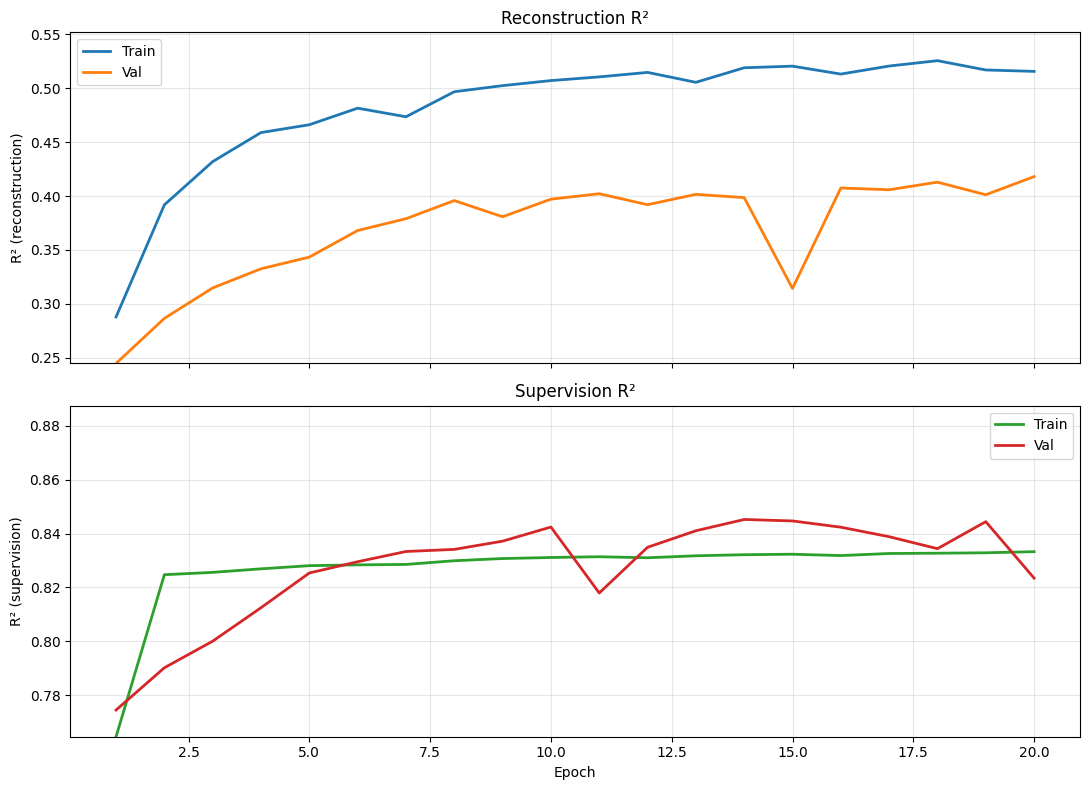

In [13]:
# define model
n_feat = len(features)
n_latent = 16
encoder_hidden = [64, 32]
decoder_hidden = [32, 64]
head_hidden = [8, 8, 4]

model = AutoEncoder(
    n_feat=n_feat,
    n_latent=n_latent,
    encoder_hidden=encoder_hidden,
    decoder_hidden=decoder_hidden,
    head_hidden=head_hidden,
)

# define optimization parameters
lr = 0.5e-2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alpha = 1.0
beta = 1.0

optimizer = Adam(model.parameters(), lr=lr)
criterion = CombinedLoss(alpha=alpha, beta=beta)
n_epochs = 20

train = train_model(
    model=model,
    train_loader=train_data_loader,
    val_loader=val_data_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    n_epochs=n_epochs,
)

# Result analysis

- Supervision task reaches a plateau around 84%
- Reconstruction is unstable
- Let's try other parameters